In [22]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from adjoint_esn.esn import ESN
from adjoint_esn.rijke_esn import RijkeESN
from adjoint_esn.utils import preprocessing as pp
from adjoint_esn.utils.enums import eParam, get_eVar
from pathlib import Path
from adjoint_esn.utils import signals as sig
import adjoint_esn.utils.visualizations as vis
from adjoint_esn.utils import errors
from scipy import signal
from functools import partial
import yaml
from adjoint_esn.validation import set_ESN
from adjoint_esn.utils.discretizations import finite_differences
import adjoint_esn.utils.solve_ode as solve_ode
from adjoint_esn.rijke_galerkin.solver import Rijke
from adjoint_esn.validation import validate, loop
from adjoint_esn.utils import scalers

In [37]:
def load_config(experiment_path):
       with open(experiment_path/'config.yml', 'r') as file:
         config = yaml.unsafe_load(file)
         return config
experiment_path=Path('../local_results/rijke/run_20231029_153121_noise_5_new') 
config = load_config(experiment_path)
results = pp.unpickle_file(experiment_path / 'results.pickle')[0]

In [39]:
integrator = 'odeint'

# number of galerkin modes
N_g = config.simulation.N_g

# simulation options
sim_dt = config.simulation.sim_dt

# directory to search for simulation data, if the data doesn't exist, 
# then it will simulate the system
data_dir=Path('..\data')

# which regimes to use for training and validation
train_param_list = results["training_parameters"]
val_param_list = results["validation_parameters"]
train_random_seeds = results["training_random_seeds"]
val_random_seeds = results["validation_random_seeds"]

train_idx_list = np.arange(len(train_param_list))
val_idx_list = np.arange(len(train_param_list),len(train_param_list)+len(val_param_list))

transient_time = config.simulation.transient_time

noise_level = config.simulation.noise_level
noise_std = 0.0
random_seed = config.random_seed

# network time step
network_dt = config.model.network_dt

washout_time = config.model.washout_time

# which states to use as input and output
# for standard ESN these should be the same, e.g. both 'eta_mu'
# for Rijke ESN, input and output should be 'eta_mu_v_tau' and 'eta_mu' respectively
input_vars = config.model.input_vars
eInputVar = get_eVar(input_vars,N_g)
output_vars = config.model.output_vars
eOutputVar = get_eVar(output_vars,N_g)

# which system parameter is passed to the ESN
param_vars=config.model.param_vars

# if using Rijke ESN what is the order of u_f(t-tau) in the inputs,
# [u_f(t-tau), u_f(t-tau)^2 ..., u_f(t-tau)^(u_f_order)]
u_f_order = config.model.u_f_order

# length of training time series
train_time = config.train.time
val_time = config.val.time

loop_names=['train','val']
loop_times = [train_time,val_time]
sim_time = config.simulation.sim_time #transient_time + 2*washout_time + train_time + val_time

DATA = {}
for loop_name in loop_names:
    DATA[loop_name]={'u_washout':[],'p_washout':[],'u':[],'p':[],'y':[],'t':[]}


full_list = np.vstack([train_param_list,val_param_list])
full_random_seeds = [*train_random_seeds,*val_random_seeds]
for p_idx, p in enumerate(full_list):
    p_sim = {'beta':p[eParam.beta], 'tau':p[eParam.tau]}
    y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                                sim_time=sim_time,sim_dt=sim_dt,
                                data_dir=data_dir,integrator=integrator)

    regime_data = pp.create_dataset(y_sim,t_sim,p_sim,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        loop_times=loop_times,
                        loop_names=loop_names,
                        input_vars=input_vars,
                        output_vars=output_vars,
                        param_vars=param_vars,
                        N_g=N_g,
                        u_f_order=u_f_order,
                        noise_level=noise_level,
                        noise_std=noise_std,
                        random_seed=full_random_seeds[p_idx],
                        tau=p_sim["tau"],
                        )
    for loop_name in loop_names:
        [DATA[loop_name][var].append(regime_data[loop_name][var]) for var in DATA[loop_name].keys()]

# dimension of the inputs
dim = DATA["train"]["u"][0].shape[1]


In [40]:
N_washout = pp.get_steps(config.model.washout_time, config.model.network_dt)
N_val = pp.get_steps(config.val.fold_time, config.model.network_dt)
# N_val = pp.get_steps(config.train.time, config.model.network_dt)
N_transient = 0
n_param = len(config.model.param_vars)

ESN_dict = {
    "reservoir_size": config.model.reservoir_size,
    "parameter_dimension": n_param,
    "reservoir_connectivity": config.model.connectivity,
    "r2_mode": config.model.r2_mode,
    "input_only_mode": config.model.input_only_mode,
    "input_weights_mode": config.model.input_weights_mode,
    "reservoir_weights_mode": config.model.reservoir_weights_mode,
    "tikhonov": results["tikhonov"][0],
    "leak_factor": results["leak_factor"][0],
    "input_scaling": results["input_scaling"][0],
    "u_f_scaling": results["u_f_scaling"][0],
    "parameter_normalization": [results["parameter_normalization_mean"][0],results["parameter_normalization_var"][0]],
    "spectral_radius": results["spectral_radius"][0]
}
if config.model.type == "standard":
    ESN_dict["dimension"] = dim
elif config.model.type == "rijke":
    ESN_dict["N_g"] = config.simulation.N_g
    ESN_dict["x_f"] = 0.2
    ESN_dict["dt"] = config.model.network_dt
    ESN_dict["u_f_order"] = config.model.u_f_order


In [32]:
tikh_in = 1e-6
tikh_end = 1
grid_range = [[tikh_in, tikh_end]]
hyp_param_names = ['tikhonov']
# scales, uniform or log10
hyp_param_scales = ['log10']

for i in range(len(grid_range)):
    for j in range(2):
        scaler = getattr(scalers, hyp_param_scales[i])
        grid_range[i][j] = scaler(grid_range[i][j])

tikhs = np.linspace(grid_range[0][0],grid_range[0][1],21)
err_train = np.zeros(len(tikhs))
err_val = np.zeros(len(tikhs))

for tikh_idx, tikh in enumerate(tikhs):
    params = [tikh]
    err_train[tikh_idx] = loop(
        params,
        hyp_param_names,
        hyp_param_scales,
        ESN_dict,
        U_washout_train=DATA["train"]["u_washout"],
        U_train=DATA["train"]["u"],
        U_val=DATA["val"]["u"],
        Y_train=DATA["train"]["y"],
        Y_val=DATA["val"]["y"],
        n_folds=config.val.n_folds,
        n_realisations=1, #config.val.n_realisations,
        N_washout=N_washout,
        N_val=N_val,
        N_trans=N_transient,
        P_washout_train=DATA["train"]["p_washout"],
        P_train=DATA["train"]["p"],
        P_val=DATA["val"]["p"],
        train_idx_list=train_idx_list,
        val_idx_list=train_idx_list,
        p_list=full_list,
        ESN_type="rijke",  # "standard" or "rijke"
        error_measure=getattr(errors, config.val.error_measure),
        LT=None,  # only needed if error measure predictability horizon
        network_dt=None,  # only needed if error measure predictability horizon
    )

for tikh_idx, tikh in enumerate(tikhs):
    params = [tikh]
    err_val[tikh_idx] = loop(
        params,
        hyp_param_names,
        hyp_param_scales,
        ESN_dict,
        U_washout_train=DATA["train"]["u_washout"],
        U_train=DATA["train"]["u"],
        U_val=DATA["val"]["u"],
        Y_train=DATA["train"]["y"],
        Y_val=DATA["val"]["y"],
        n_folds=config.val.n_folds,
        n_realisations=1, #config.val.n_realisations,
        N_washout=N_washout,
        N_val=N_val,
        N_trans=N_transient,
        P_washout_train=DATA["train"]["p_washout"],
        P_train=DATA["train"]["p"],
        P_val=DATA["val"]["p"],
        train_idx_list=train_idx_list,
        val_idx_list=val_idx_list,
        p_list=full_list,
        ESN_type="rijke",  # "standard" or "rijke"
        error_measure=getattr(errors, config.val.error_measure),
        LT=None,  # only needed if error measure predictability horizon
        network_dt=None,  # only needed if error measure predictability horizon
    )

--NEW RUN-- 88
Realisation: 0
tikhonov 1e-06


Val regime: 0
Val regime error: 0.10293010430513024
Val regime: 1
Val regime error: 0.1073620668732919
Val regime: 2
Val regime error: 0.10002046373061324
Val regime: 3
Val regime error: 0.10573117592651368
Val regime: 4
Val regime error: 0.35998316413268105
Realisation error: 0.15520539499364602


Run 88 error: 0.15520539499364602
Error: 0.15520539499364602


--NEW RUN-- 89
Realisation: 0
tikhonov 1.9952623149688787e-06


Val regime: 0
Val regime error: 0.10237277834369593
Val regime: 1
Val regime error: 0.110527932710008
Val regime: 2
Val regime error: 0.10070071348819094
Val regime: 3
Val regime error: 0.10556786437417003
Val regime: 4
Val regime error: 0.268783534095267
Realisation error: 0.13759056460226637


Run 89 error: 0.13759056460226637
Error: 0.13759056460226637


--NEW RUN-- 90
Realisation: 0
tikhonov 3.981071705534969e-06


Val regime: 0
Val regime error: 0.10097445015338469
Val regime: 1
Val regime error: 0.10769453108975054

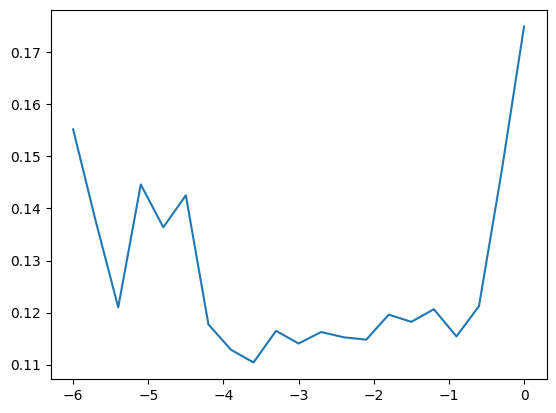

In [36]:
# plt.plot(tikhs, err_train)
plt.plot(tikhs, err_val)

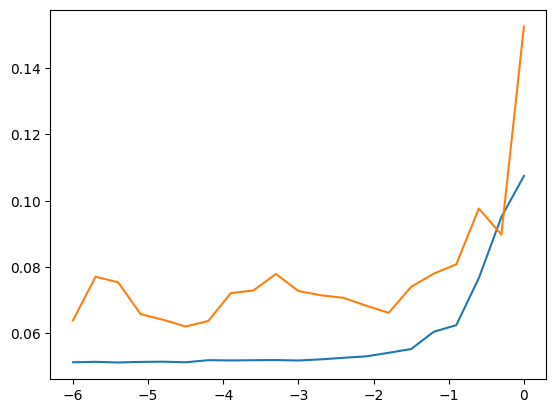

In [18]:
plt.plot(tikhs, err_train)
plt.plot(tikhs, err_val)